In [1]:
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from IPython.display import Image
import tensorflow as tf
import keras
from omnifold.net import weighted_binary_crossentropy
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
# Register OmniFold custom loss so Keras 3 can clone models
keras.saving.register_keras_serializable(package="omnifold")(weighted_binary_crossentropy)
import os

gpu_number="7"
os.environ['CUDA_VISIBLE_DEVICES']=gpu_number # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']=gpu_number
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)


2025-12-07 16:06:34.979626: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 16:06:34.996366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765119995.013226 1109880 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765119995.018314 1109880 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765119995.032639 1109880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from omnifold import DataLoader, MultiFold, PET, SetStyle, HistRoutine

sys.path.append('/scratch/mjosef/Unfolding/test/omnifold')

In [3]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar_singletop_DR.pkl')

In [4]:
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
import PET
from my_utils import *
pythia_train, pythia_test = subset(pythia_df, 1_000_000, train_test=True)
herwig_subset = subset(herwig_df, 1_000_000, train_test=False)

pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train[pythia_train["pass_matched"]==1])
pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test[pythia_test["pass_matched"]==1])
herwig_reco, herwig_truth = MC_data_shaper(herwig_subset[herwig_subset["pass_matched"]==1])

In [5]:
omnifold_name = "pc_test"
weight_folder = '/scratch/mjosef/Unfolding/omnifold/pc_test'

In [6]:
class JetScaler:
    def __init__(self, mask_value=0.0):
        self.mask_value = mask_value
        self.scaler = StandardScaler()
    
    def _valid_mask(self, X):
        """
        Returns a boolean mask of jets that are *not* padding.
        Padding jets are those where all 4 features == mask_value.
        """
        return ~np.all(X == self.mask_value, axis=-1)
    
    def fit(self, X):
        """
        Fit the scaler only on valid (non-padded) jets.
        """
        X = np.array(X, dtype=float)
        valid_mask = self._valid_mask(X)
        valid_jets = X[valid_mask]
        self.scaler.fit(valid_jets)
    
    def transform(self, X):
        """
        Transform valid jets, leave padded jets at mask_value.
        """
        X = np.array(X, dtype=float)
        orig_shape = X.shape
        valid_mask = self._valid_mask(X)
        
        X_flat = X.reshape(-1, X.shape[-1])
        X_scaled = np.zeros_like(X_flat)
        
        # Only transform valid jets
        X_scaled[valid_mask.reshape(-1)] = self.scaler.transform(X_flat[valid_mask.reshape(-1)])
        
        # Keep masked jets as mask_value (usually 0)
        X_scaled[~valid_mask.reshape(-1)] = self.mask_value
        
        return X_scaled.reshape(orig_shape)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_herwig_reco_scaled = jet_scaler.transform(herwig_reco)
X_herwig_truth_scaled = jet_scaler.transform(herwig_truth)
Y_truth_scaled = jet_scaler.transform(pythia_truth_test)
Y_reco_scaled = jet_scaler.transform(pythia_reco_test)

In [14]:
herwig_loader = DataLoader(reco = X_herwig_reco_scaled, gen = X_herwig_truth_scaled, weight = herwig_subset[herwig_subset["pass_matched"]==1]['eventWeight'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled, gen = X_pythia_truth_scaled, weight = pythia_train[pythia_train["pass_matched"]==1]['eventWeight'], normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_test[pythia_test["pass_matched"]==1]['eventWeight'], normalize=False)

INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


In [15]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 12 # 14 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 12, local=False)
model2 = PET.PET(num_feat = 4, num_part = 12, local=False)

## Let's now create the neural network models we are going to use to model the weight distributions

In [9]:
model1.build(input_shape = (1,12,4))
print(model1.summary())

/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "pet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention            │ ?                      │   0 (unbuilt) │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_1          │ ?                      │   0 (unbuilt) │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_scale (LayerScale)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_scale_1 (LayerScale)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_scale_2 (LayerScale)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_scale_3 (LayerScale)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ particle_mask (ParticleMask)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_average_pooling          │ ?                      │   0 (unbuilt) │
│ (MaskedAveragePooling)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32 (128.00 B)

 Trainable params: 32 (128.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Let's now unfold!

In [16]:
omnifold = MultiFold(
    omnifold_name,
    model1,
    model2,
    herwig_loader,
    pythia_loader,
    batch_size = 512,
    niter = 5,  #Number of Iterations                     
    epochs=100,     
    weights_folder = weight_folder,
    verbose = True,
    lr = 5e-5,
)

1096 training steps at reco and 1174 steps at gen


In [17]:
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 561152, Test events used: 112230
################################################################################
Epoch 1/100


I0000 00:00:1765120211.565861 1110646 service.cc:152] XLA service 0x7f44fc038430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765120211.565903 1110646 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-12-07 16:10:11.691340: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765120212.529267 1110646 cuda_dnn.cc:529] Loaded cuDNN version 90501


 52/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.5779

I0000 00:00:1765120218.352941 1110646 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


876/876 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 7.5451 - val_loss: 7.5169 - learning_rate: 5.0000e-05
Epoch 2/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.5151 - val_loss: 7.4512 - learning_rate: 5.0000e-05
Epoch 3/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.4766 - val_loss: 7.4362 - learning_rate: 5.0000e-05
Epoch 4/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.4396 - val_loss: 7.4246 - learning_rate: 5.0000e-05
Epoch 5/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.4476 - val_loss: 7.4132 - learning_rate: 5.0000e-05
Epoch 6/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.4398 - val_loss: 7.4084 - learning_rate: 5.0000e-05
Epoch 7/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.4172 - val_loss: 7.3984 - learning_rate: 5.0000e-05
Epoch 8/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.3963 - val_loss: 7.3948 - learning_rate: 5.0000e-05
Epoch 9/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.4001 - val_loss: 7.3949 - le

In [18]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled,omnifold.model2,batch_size=1000)

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


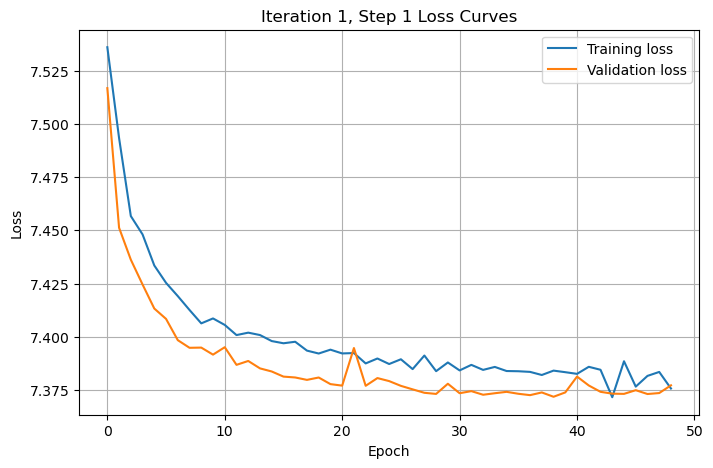

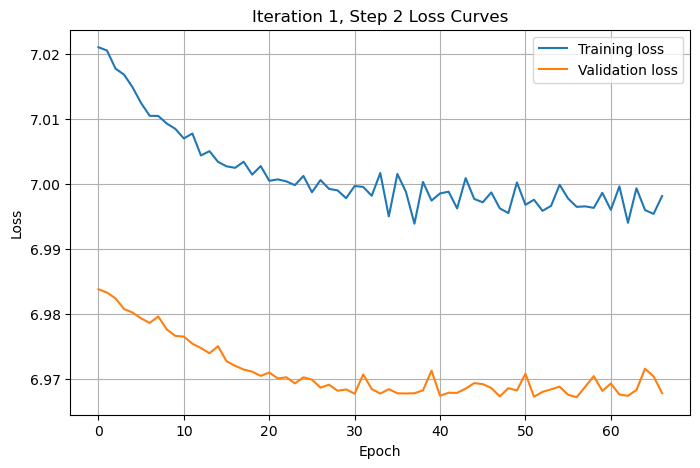

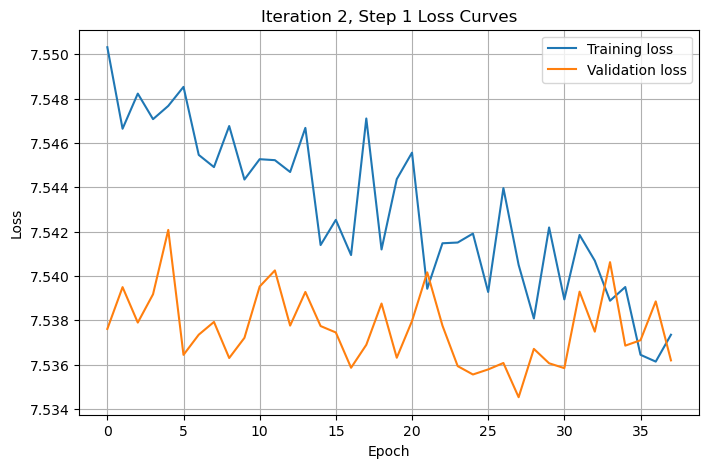

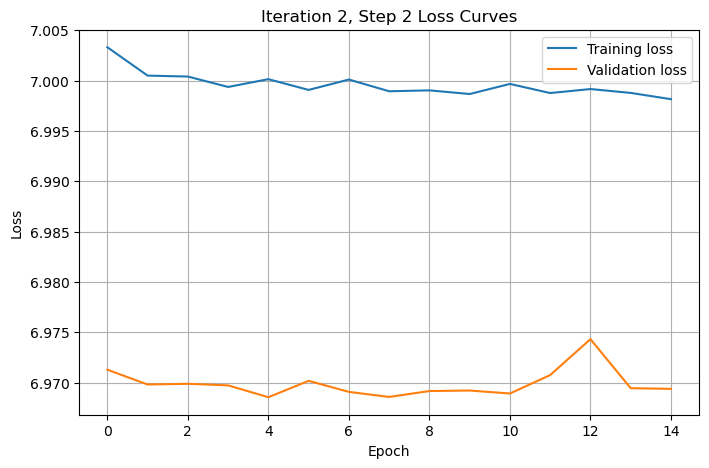

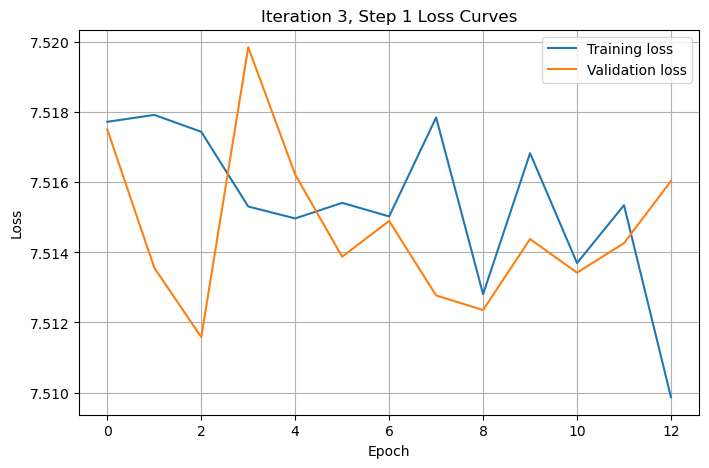

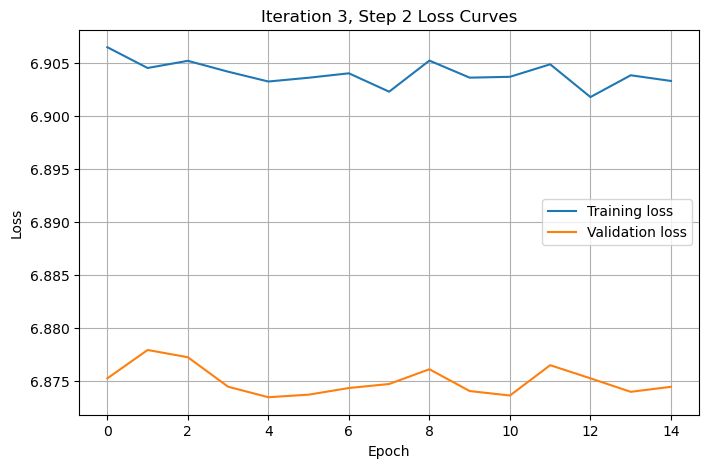

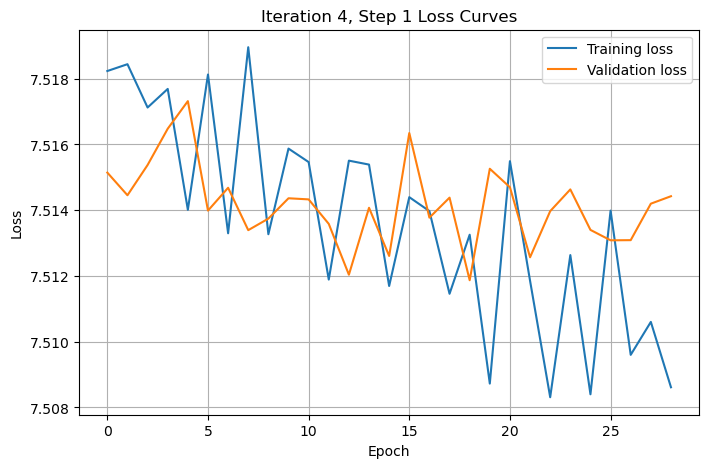

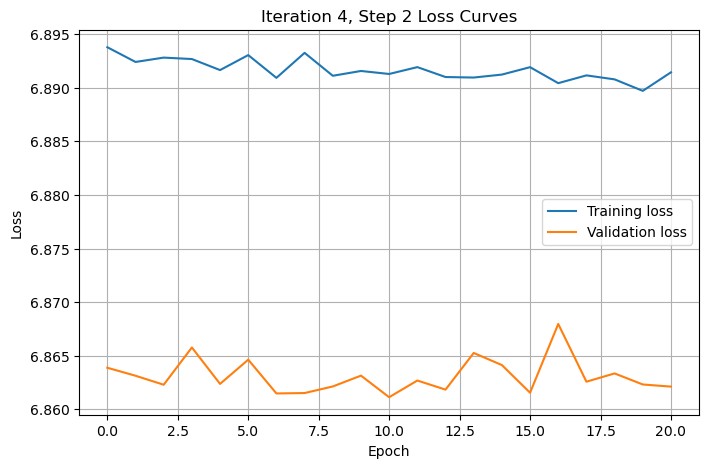

In [19]:
import pickle
# Set these to your parameters
niter = 4                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weight_folder}/OmniFold_{omnifold_name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()

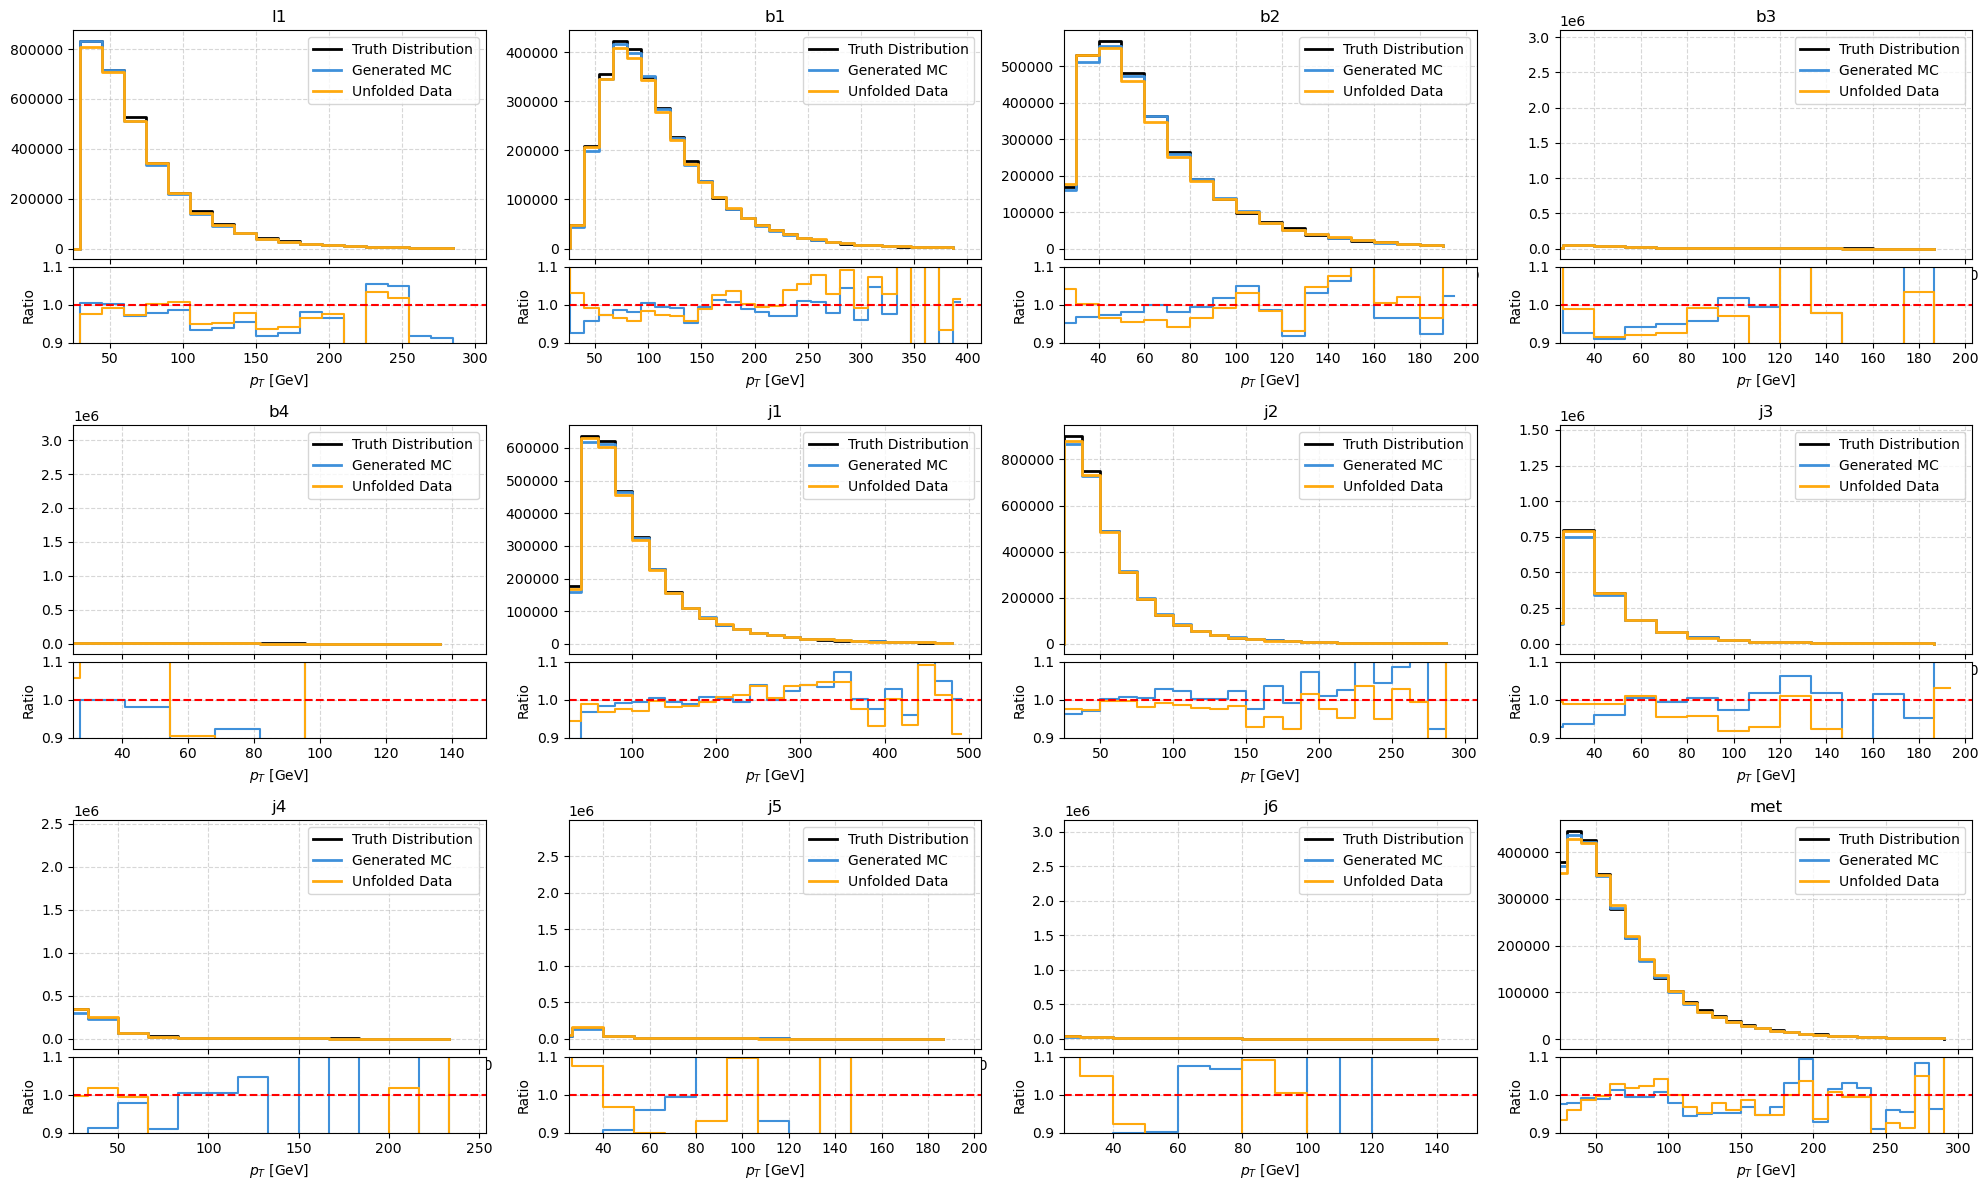

In [26]:
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 
             'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 300, 21),
    'b1': np.linspace(0, 400, 31),
    'b2': np.linspace(0, 200, 21),
    'b3': np.linspace(0, 200, 16),
    'b4': np.linspace(0, 150, 12),
    'j1': np.linspace(0, 500, 26),
    'j2': np.linspace(0, 300, 25),
    'j3': np.linspace(0, 200, 16),
    'j4': np.linspace(0, 250, 16),
    'j5': np.linspace(0, 200, 16),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}

# Function to plot one particle pt with ratio
def plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, bins):
    x_centers = 0.5 * (bins[1:] + bins[:-1])
    
    # Reference histogram: first entry
    ref_name = list(data_dict.keys())[0]
    ref_counts, _ = np.histogram(data_dict[ref_name], bins=bins, weights=weights_dict[ref_name])
    
    maxy = 0
    colors = ['black', '#3f90da', '#ffa90e', '#bd1f01']  # adjust as needed
    
    for i, (label, values) in enumerate(data_dict.items()):
        counts, _ = np.histogram(values, bins=bins, weights=weights_dict[label])
        ax_main.step(bins[:-1], counts, where='post', color=colors[i], label=label, linewidth=2)
        maxy = max(maxy, counts.max())
        
        if ax_ratio is not None and i > 0:  # skip reference
            ratio = np.divide(counts, ref_counts, out=np.zeros_like(counts), where=ref_counts!=0)
            ax_ratio.step(x_centers, ratio, where='mid', color=colors[i], label=f"{label}/{ref_name}")
    
    #ax_main.set_ylim(0, 1.3*maxy)
    ax_main.set_xlim(25,)
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.legend(fontsize=10)
    if ax_ratio is not None:
        ax_ratio.axhline(1.0, color='r', linestyle='--')
        ax_ratio.set_ylim(0.9, 1.1)
        ax_ratio.set_xlabel(r"$p_T$ [GeV]")
        ax_ratio.set_ylabel("Ratio")
        ax_ratio.grid(True, linestyle='--', alpha=0.5)

# --- Create figure with 3x4 subplots ---
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for i, pname in enumerate(particles[:12]):
    # Prepare data
    data_dict = {
        'Truth Distribution': herwig_truth[:, i, 0],
        'Generated MC': pythia_truth_test[:, i, 0],
        'Unfolded Data': pythia_truth_test[:, i, 0],
    }
    weight_dict = {
        'Truth Distribution': herwig_loader.weight,
        'Generated MC': testset_loader.weight,
        'Unfolded Data': (unfolded_weights * testset_loader.weight),
    }
    
    # Create a small inset for ratio
    # Here we just stack main+ratio manually inside the same subplot
    # Define height ratios
    gs = axes[i].get_gridspec()
    for ax in axes[i].get_shared_x_axes().get_siblings(axes[i]):
        ax.remove()
    
    from matplotlib.gridspec import GridSpecFromSubplotSpec
    sub_gs = GridSpecFromSubplotSpec(2, 1, height_ratios=[3,1], subplot_spec=gs[i], hspace=0.05)
    ax_main = fig.add_subplot(sub_gs[0])
    ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
    
    plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
    
    ax_main.set_title(pname)

plt.tight_layout()
plt.show()

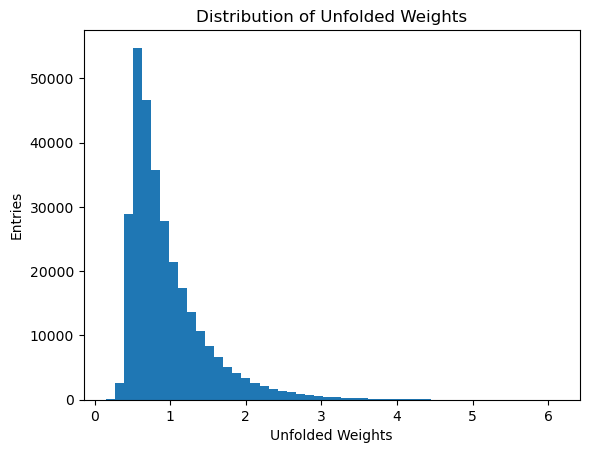

In [24]:
plt.hist(unfolded_weights, bins=50)
#plt.yscale('log')
plt.xlabel('Unfolded Weights')
plt.ylabel('Entries')
plt.title('Distribution of Unfolded Weights')
plt.show()

In [26]:
n_iterations   = 4
n_ensembles    = 1
weights_plots_folder = f"weight_plots_{omnifold_name}"
os.makedirs(os.path.join(weight_folder, weights_plots_folder), exist_ok=True)

def expit(x):
    return 1. / (1. + np.exp(-x))

# --------------------------------------------------------
# LOAD WEIGHTS FUNCTION
def load_unfolded_weights(iteration, stepn, ensemble=0):
    model_name = f"{weight_folder}/OmniFold_{omnifold_name}_iter{iteration}_step{stepn}"
    if n_ensembles > 1:
        model_name += f"_ensemble{ensemble}"
    model_name += ".weights.h5"

    if not os.path.exists(model_name):
        return None

    if stepn ==1:
        my_model = omnifold_result.model1
        iterative_weights = np.zeros((len(Y_reco_scaled)))
        in_data = Y_reco_scaled
    elif stepn==2:
        my_model = omnifold_result.model2
        iterative_weights = np.zeros((len(Y_truth_scaled)))
        in_data = Y_truth_scaled

    # 🧩 Ensure model is built before loading weights
    _ = my_model.build(input_shape=(None, 12, 4))    # or use my_model.build(input_shape=(None, Y_truth_scaled.shape[1]))

    my_model.load_weights(model_name)
    f = expit(my_model.predict(in_data,batch_size=1000))
    weights = f / (1. - f)  # this is the crux of the reweight, approximates likelihood ratio
    weights = np.nan_to_num(weights[:,0],posinf=1)
    iterative_weights += weights
    return iterative_weights

# --------------------------------------------------------
# PLOT FOR EACH ITERATION
# --------------------------------------------------------
def plot_iteration(iteration, unfolded_weights, stepn):
    fig = plt.figure(figsize=(20, 12))
    outer_gs = fig.add_gridspec(3, 4, wspace=0.3, hspace=0.3)

    for i, pname in enumerate(particles[:12]):
        sub_gs = GridSpecFromSubplotSpec(2, 1, height_ratios=[3,1],
                                         subplot_spec=outer_gs[i], hspace=0.05)
        ax_main = fig.add_subplot(sub_gs[0])
        ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
        if stepn==1:
            data_dict = {
                'Pseudo-Data Reco-Level': herwig_reco[:, i, 0][herwig_reco[:, i, 0] != 0],
                'MC Reco-Level': pythia_reco_test[:, i, 0][pythia_reco_test[:, i, 0] != 0],
                'Reweighted Reco-Level (OmniFold)': pythia_reco_test[:, i, 0][pythia_reco_test[:, i, 0] != 0],
            }
            weight_dict = {
                'Pseudo-Data Reco-Level': herwig_subset['eventWeight'][herwig_reco[:, i, 0] != 0],
                'MC Reco-Level': pythia_test['eventWeight'][pythia_reco_test[:, i, 0] != 0],
                'Reweighted Reco-Level (OmniFold)': (unfolded_weights * pythia_test['eventWeight'])[pythia_reco_test[:, i, 0] != 0],
            }

            plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
            ax_main.set_title(pname, fontsize=10)
            fig.suptitle("Reco-Level", fontsize=16)

        elif stepn==2:
            data_dict = {
                'Truth Distribution': herwig_truth[:, i, 0][herwig_truth[:, i, 0] != 0],
                'Generated MC': pythia_truth_test[:, i, 0][pythia_truth_test[:, i, 0] != 0],
                'Unfolded Data': pythia_truth_test[:, i, 0][pythia_truth_test[:, i, 0] != 0],
            }
            weight_dict = {
                'Truth Distribution': herwig_subset['eventWeight'][herwig_truth[:, i, 0] != 0],
                'Generated MC': pythia_test['eventWeight'][pythia_truth_test[:, i, 0] != 0],
                'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])[pythia_truth_test[:, i, 0] != 0],
            }

            plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
            ax_main.set_title(pname, fontsize=10)
            fig.suptitle("Particle-Level", fontsize=16)

    plt.tight_layout()
    out_path = os.path.join(weight_folder, weights_plots_folder, f"plot_iter{iteration+1}_step{stepn}.png")
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"Saved 3×4 grid plot for iteration {iteration+1}")


# --------------------------------------------------------
# MAIN LOOP
# --------------------------------------------------------
for i in range(n_iterations):
    omnifold_weights = load_unfolded_weights(i, stepn=1)
    if omnifold_weights is not None:
        plot_iteration(i, omnifold_weights, stepn=1)

/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step


/tmp/ipykernel_3578794/212660305.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved 3×4 grid plot for iteration 1
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step
Saved 3×4 grid plot for iteration 2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step
Saved 3×4 grid plot for iteration 3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step
Saved 3×4 grid plot for iteration 4


## Now, let's evaluate the model!

In [15]:
validation_data = np.random.normal(size=(5*nevts,npart,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
unfolded_weights  = omnifold.reweight(validation_data,omnifold.model2,batch_size=1000)   

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step


In [16]:
print(unfolded_weights)

[6.65853877e-05 4.21522474e+00 6.59831017e-02 ... 2.52300519e-02
 5.59463879e-05 7.99300142e-06]


## More plots!

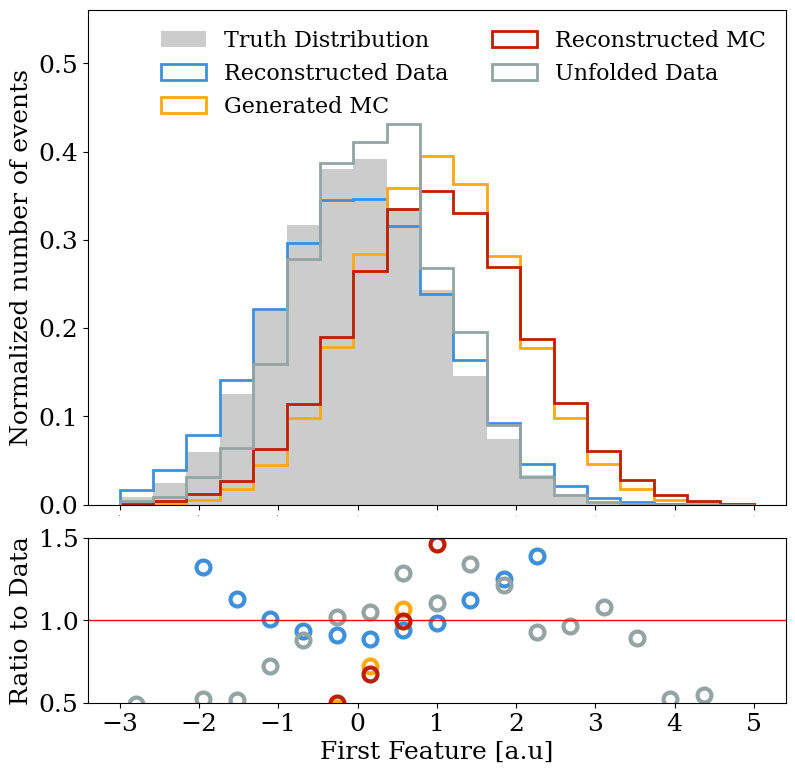

In [17]:
data_dict = {
    'Truth Distribution': gen_data[:,0,0],
    'Reconstructed Data': reco_data[:,0,0],
    'Generated MC': gen_mc[:,0,0],
    'Reconstructed MC': reco_mc[:,0,0],
    'Unfolded Data': validation_data[:,0,0],
}

weight_dict = {
    'Truth Distribution': data.weight,
    'Reconstructed Data': data.weight,
    'Generated MC': mc.weight,
    'Reconstructed MC': mc.weight,
    'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,'First Feature [a.u]',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    binning = np.linspace(-3,5,20)
                    )
